In [2]:
# Load the required modules
import sys
sys.path.append("../..")
from datasetGenerator import DCASE2018
from Encoder import Encoder
from Binarizer import Binarizer

from keras.layers import GRU, Bidirectional, Layer, TimeDistributed, Dense, GRUCell
from keras.models import model_from_json, Model
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from subprocess import call

import librosa.display
import librosa
import numpy as np
import os
import copy

Using TensorFlow backend.


In [3]:
# Load the test data create the test dataset
# load the file list
featTestPath = "/homeLocal/eriador/Documents/Corpus/DCASE2018/features_2/test/mel"
featTestList = os.listdir(featTestPath)

# load the meta data ----
metaPath = "/homeLocal/eriador/Documents/Corpus/DCASE2018/meta/test.csv"
with open(metaPath, "r") as metaFile:
    metadata = metaFile.read().splitlines()[1:]
    
metadata = [i.split("\t") for i in metadata]

# load the features
featTest = []
for file in featTestList:
    path = os.path.join(featTestPath, file)
    feature = np.load(path)
    
    # preprocessing
    feature = np.expand_dims(feature, axis=-1)
    featTest.append(feature)
    
featTest = np.array(featTest)

# Custom implementation for GRU and GRUCell

In [4]:
class CustomGRUCell(GRUCell):

    def __init__(self, units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True,
                 kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
                 kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, kernel_constraint=None,
                 recurrent_constraint=None, bias_constraint=None, dropout=0., recurrent_dropout=0., implementation=1,
                 reset_after=False, temporal_weight: float = 0.5, **kwargs):

        self.temporal_weight = temporal_weight

        super().__init__(units, activation, recurrent_activation, use_bias, kernel_initializer, recurrent_initializer,
                         bias_initializer, kernel_regularizer, recurrent_regularizer, bias_regularizer,
                         kernel_constraint, recurrent_constraint, bias_constraint, dropout, recurrent_dropout,
                         implementation, reset_after, **kwargs)
        
        print("Temporal weight : ", self.temporal_weight)


    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        # if 0 < self.dropout < 1 and self._dropout_mask is None:
        #     self._dropout_mask = _generate_dropout_mask(
        #         K.ones_like(inputs),
        #         self.dropout,
        #         training=training,
        #         count=3)
        # if (0 < self.recurrent_dropout < 1 and
        #         self._recurrent_dropout_mask is None):
        #     self._recurrent_dropout_mask = _generate_dropout_mask(
        #         K.ones_like(h_tm1),
        #         self.recurrent_dropout,
        #         training=training,
        #         count=3)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_z = inputs * dp_mask[0]
                inputs_r = inputs * dp_mask[1]
                inputs_h = inputs * dp_mask[2]
            else:
                inputs_z = inputs
                inputs_r = inputs
                inputs_h = inputs

            x_z = K.dot(inputs_z, self.kernel_z)
            x_r = K.dot(inputs_r, self.kernel_r)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_z = K.bias_add(x_z, self.input_bias_z)
                x_r = K.bias_add(x_r, self.input_bias_r)
                x_h = K.bias_add(x_h, self.input_bias_h)

                
                
                
                
                
                
                
                
            if 0. < self.recurrent_dropout < 1.:
                h_tm1_z = h_tm1 * self.temporal_weight #rec_dp_mask[0]
                h_tm1_r = h_tm1 * self.temporal_weight #rec_dp_mask[1]
                h_tm1_h = h_tm1 * self.temporal_weight #rec_dp_mask[2]
            else:
                h_tm1_z = h_tm1 * self.temporal_weight
                h_tm1_r = h_tm1 * self.temporal_weight
                h_tm1_h = h_tm1 * self.temporal_weight

                
                
                
                
                
                
            recurrent_z = K.dot(h_tm1_z, self.recurrent_kernel_z)
            recurrent_r = K.dot(h_tm1_r, self.recurrent_kernel_r)
            if self.reset_after and self.use_bias:
                recurrent_z = K.bias_add(recurrent_z, self.recurrent_bias_z)
                recurrent_r = K.bias_add(recurrent_r, self.recurrent_bias_r)

            z = self.recurrent_activation(x_z + recurrent_z)
            r = self.recurrent_activation(x_r + recurrent_r)

            # reset gate applied after/before matrix multiplication
            if self.reset_after:
                recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
                if self.use_bias:
                    recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
                recurrent_h = r * recurrent_h
            else:
                recurrent_h = K.dot(r * h_tm1_h, self.recurrent_kernel_h)

            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_z = matrix_x[:, :self.units]
            x_r = matrix_x[:, self.units: 2 * self.units]
            x_h = matrix_x[:, 2 * self.units:]

            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            if self.reset_after:
                # hidden state projected by all gate matrices at once
                matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
                if self.use_bias:
                    matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            else:
                # hidden state projected separately for update/reset and new
                matrix_inner = K.dot(h_tm1,
                                     self.recurrent_kernel[:, :2 * self.units])

            recurrent_z = matrix_inner[:, :self.units]
            recurrent_r = matrix_inner[:, self.units: 2 * self.units]

            z = self.recurrent_activation(x_z + recurrent_z)
            r = self.recurrent_activation(x_r + recurrent_r)

            if self.reset_after:
                recurrent_h = r * matrix_inner[:, 2 * self.units:]
            else:
                recurrent_h = K.dot(r * h_tm1,
                                    self.recurrent_kernel[:, 2 * self.units:])

            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = z * h_tm1 + (1 - z) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]


class CustomGRU(GRU):

    def __init__(self, units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True,
                 kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
                 kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.,
                 recurrent_dropout=0., implementation=1, return_sequences=False, return_state=False, go_backwards=False,
                 stateful=False, unroll=False, reset_after=False, temporal_weight: float = 0.5, **kwargs):

        """
        super().__init__(units, activation=activation, recurrent_activation=recurrent_activation,
                         use_bias=use_bias, kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer,
                         bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer,
                         recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer,
                         activity_regularizer=activity_regularizer, kernel_constraint=kernel_constraint,
                         recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint,
                         dropout=dropout, recurrent_dropout=recurrent_dropout, implementation=implementation,
                         return_sequences=return_sequences, return_state=return_state, go_backwards=go_backwards,
                         stateful=stateful, unroll=unroll, reset_after=reset_after, **kwargs)
        """
        
        self.temporal_weight = temporal_weight

        cell = CustomGRUCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation,
                       reset_after=reset_after,
                       temporal_weight=temporal_weight)

        super(GRU, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        
        
        
    def get_config(self):
        config = super().get_config()
        config["temporal_weight"] = self.temporal_weight
        return config
        
    def call(self, inputs, mask=None, training=None, initial_state=None):
        return super().call(inputs, mask, True, initial_state)
        
    

# Load the model

In [5]:
modelJsonPath = "/homeLocal/eriador/Documents/DCASE2018/results/testing/mel_old_noBlank_timeReduction2/oldMel_noBlank_reduce2_model.json"
modelWeightPath = "/homeLocal/eriador/Documents/DCASE2018/results/testing/mel_old_noBlank_timeReduction2/oldMel_noBlank_reduce2_weight.h5py"

# Classic

In [ ]:
##### load the model and perform prediction
K.clear_session()

with open(modelJsonPath, "r") as modelJsonFile:
    model = model_from_json(modelJsonFile.read())
model.load_weights(modelWeightPath)

# retreive information about the custom
#prediction = intermediate_model.predict(featTest)
print("done")

# With GRU and TimeDistributed
## Remove the GlobalAveragePooling1D to trace score per frames

In [38]:
##### load the model and perform prediction
K.clear_session()

with open(modelJsonPath, "r") as modelJsonFile:
    model = model_from_json(modelJsonFile.read())
model.load_weights(modelWeightPath)

#disasemble layers
layers = [l for l in model.layers]

# Get the trained forward layer from the bidirectional and change it's property
b1 = model.get_layer("bidirectional_1")

x = layers[0].output
for i in range(1, len(layers)):
    if layers[i].name == "bidirectional_1":
        x = Bidirectional(
            GRU(units=64, kernel_initializer='glorot_uniform', recurrent_dropout=0.8, dropout=0.0, return_sequences=True))(x)
    elif layers[i].name == "time_distributed_1":
        x = TimeDistributed( Dense(10, activation="sigmoid"), )(x)
    else:
        x = layers[i](x)

newModel = Model(input=layers[0].input, output=x)
newModel.load_weights(modelWeightPath)
#model.summary()

intermediate_model = Model(input=model.input, output=newModel.get_layer("time_distributed_1").output)
#intermediate_model.summary()


# retreive information about the custom
prediction = intermediate_model.predict(featTest)
print("done")

/homeLocal/eriador/.miniconda3/envs/dcase/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
/homeLocal/eriador/.miniconda3/envs/dcase/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`


done


# With ***Custom*** GRU and TimeDistributed
## Remove the GlobalAveragePooling1D to trace score per frames

In [63]:
##### load the model and perform prediction
K.clear_session()

with open(modelJsonPath, "r") as modelJsonFile:
    model = model_from_json(modelJsonFile.read())
model.load_weights(modelWeightPath)

#disasemble layers
layers = [l for l in model.layers]

# Get the trained forward layer from the bidirectional and change it's property
b1 = model.get_layer("bidirectional_1")

x = layers[0].output
for i in range(1, len(layers)):
    if layers[i].name == "bidirectional_1":
        x = Bidirectional(
            CustomGRU(units=64, kernel_initializer='glorot_uniform', recurrent_dropout=0.8, dropout=0.0, return_sequences=True, temporal_weight=0.25), name="custom_bi")(x)
    elif layers[i].name == "time_distributed_1":
        x = TimeDistributed( Dense(10, activation="sigmoid"), )(x)
    else:
        x = layers[i](x)

newModel = Model(input=layers[0].input, output=x)
newModel.load_weights(modelWeightPath)
#model.summary()

intermediate_model = Model(input=model.input, output=newModel.get_layer("time_distributed_1").output)
#intermediate_model.summary()


# retreive information about the custom
prediction = intermediate_model.predict(featTest)
print("done")

Temporal weight :  0.25
Temporal weight :  0.25


/homeLocal/eriador/.miniconda3/envs/dcase/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
/homeLocal/eriador/.miniconda3/envs/dcase/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`


done


# ***Without*** GRU and TimeDistributed
## Remove the GlobalAveragePooling1D to trace score per frames

In [ ]:
##### load the model and perform prediction
K.clear_session()

with open(modelJsonPath, "r") as modelJsonFile:
    model = model_from_json(modelJsonFile.read())
model.load_weights(modelWeightPath)

intermediate_model = Model(input=model.input, output=model.get_layer("time_distr￼ibuted_1").output)
#intermediate_model.summary()
￼

# retreive information about the custom
prediction = intermediate_model.predict(featTest)
print(prediction.shape)

# Load the dataset and perform a prediction on the *validation* dataset

In [7]:
# load the dataset
featRoot = "/homeLocal/eriador/Documents/Corpus/DCASE2018/features_2/"
metaRoot = "/homeLocal/eriador/Documents/Corpus/DCASE2018/meta"
feat =  ["mel"]
normalizer = None

dataset = DCASE2018(
        featureRoot=featRoot,
        metaRoot=metaRoot,
        features=feat,
        expandWithUod=False,
        validationPercent=0.2,
        normalizer=normalizer
    )

mel


In [32]:
# Perform the prediction￼
vPred = dataset.validationDataset["mel"]["input"]
vTrue = dataset.validationDataset["mel"]["output"]

# calc metrics for each classes separately
print("prediction...")
prediction = model.predict(np.array(vPred))
print("done")


mel
prediction...
done


# optimization
## Several methods available
 - "metrics"
 - "auc"

In [ ]:
b = Binarizer()
b.optimize(vTrue, prediction)
thresholds = b.thresholds

# Display method
### Draw score over time for each classes.
### Draw boudaries from ground truth

In [58]:
aaaaaaaaaaaaaaaaa = []

In [80]:
patchessss = []

In [96]:
# process the prediction (intermediate model)
nbFileToDisplay = 1
boundaries = True

classes = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water".split(",")
output = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water\n"
Colors = "C0,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,#c2c2c2".split(",")

nbFrame = prediction.shape[1]
frameLength = 10 / nbFrame

def getClasses(file):
    output = ""
    for info in metadata:
        if info[0] == file[:-4]:
            output += ",".join(info[1:]) + "\n"
            
    return output
    
    
def display(filePath, patches: str = "test", encoded = None):
    def patchFromStr():
        # add patches to highlight ground truth
        tBoundaries = rawBoundaries.split("\n")
        for line in tBoundaries:
            info = line.split(",")
            if len(info) == 3:
                color = Colors[classes.index(info[2])]
                start = float(info[0])
                end = float(info[1]) - float(info[0])
                rect = patch.Rectangle(
                    (start,0),end,1,
                    linewidth=1,
                    edgecolor=color,
                    facecolor=color,
                    alpha=0.08)
                patchessss.append(rect)
                #ax.add_patch(rect)
                
    def patchFromEncoder(encoded: dict):
        for cls in encoded:
            start = 0
            for segment in encoded[cls]:
                # if empty, pass to the next
                if len(segment) == 0:
                    continue
                
                if segment[0] == 1:      # Only for positive segment
                    color = Colors[cls+1]
                    end = (segment[1] * frameLength)
                    rect = patch.Rectangle((start * frameLength, 0), end, 1, linewidth=1, edgecolor=color, facecolor=color, alpha=0.25)
                    patchessss.append(rect)
                    #ax.add_patch(rect)
                    print("start: ", start, "rect : ", rect)
                    start += segment[1]
                
                else:
                    start += segment[1]
                    
        

    with open(filePath, "r") as f:
        raw = f.readlines()[1:]
    data = []
    for r in raw:
        data.append(r[:-1].split(","))
        
    data = np.array(data)
    time = np.array(data[:,0], np.float32)
    alarm = np.array(data[:,1], np.float32)
    speech = np.array(data[:,2], np.float32)
    dog = np.array(data[:,3], np.float32)
    aaaaaaaaaaaaaaaaa.append(dog)
    cat = np.array(data[:,4], np.float32)
    vac = np.array(data[:,5], np.float32)
    dishes = np.array(data[:,6], np.float32)
    frying = np.array(data[:,7], np.float32)
    elec = np.array(data[:,8], np.float32)
    blend = np.array(data[:,9], np.float32)
    run = np.array(data[:,10], np.float32)
    #blk = np.array(data[:,11], np.float32)
    
    fig, ax = plt.subplots(1, figsize=(18,6))
    plt.title(filePath[:-8], fontsize=24)
    plt.xlabel("time (s)", fontsize=16)
    plt.ylabel("probability P(t)", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ax.plot(time, alarm, label="alarm", color=Colors[classes.index("Alarm_bell_ringing")])
    ax.plot(time, speech, label="speech", color=Colors[classes.index("Speech")])
    ax.plot(time, dog, label="dog", color=Colors[classes.index("Dog")])
    ax.plot(time, cat, label="cat", color=Colors[classes.index("Cat")])
    ax.plot(time, vac, label="vac", color=Colors[classes.index("Vacuum_cleaner")])
    ax.plot(time, dishes, label="dishes", color=Colors[classes.index("Dishes")])
    ax.plot(time, frying, label="frying", color=Colors[classes.index("Frying")])
    ax.plot(time, elec, label="elec", color=Colors[classes.index("Electric_shaver_toothbrush")])
    ax.plot(time, blend, label="blend", color=Colors[classes.index("Blender")])
    ax.plot(time, run, label="run", color=Colors[classes.index("Running_water")])
    #ax.plot(time, blk, label="blk", color=Colors[classes.index("blank")])
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.00))
    
    # add patches to highlight ground truth
    if patches == "test": patchFromStr()
    elif patches == "encoder": patchFromEncoder(encoded)
    
    plt.show()

# Ground Truth segmentation

In [ ]:
import pandas as pd

test_df = pd.read_csv("../../meta/test.csv", sep="\t")

fileWithDishes = test_df.loc[test_df.event_label == "Dishes"].filename.values
fileWithDishes = np.unique(fileWithDishes)
fileWithDishes

In [ ]:

for i, filename in enumerate(dataset.testFileList):
    if filename[:-4] in fileWithDishes:
        clip = prediction[i]
        file = featTestList[i]
        nbFrame = prediction.shape[1]
        frameLength = 10 / nbFrame
        print(file)
        rawBoundaries = getClasses(file)
        print(rawBoundaries)

        classes = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water".split(",")
        output = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water\n"

        with open(file + ".csv", "w") as toSave:
            frameCounter = 0
            for frame in clip:
                frameCounter += 10 / nbFrame
                output += "%.4f," % frameCounter
                for cls in frame:
                    output += "%.4f," % cls
                output += "\n"
            toSave.write(output)

        display(file + ".csv", patches="test")
        
# clean the CSV files
call(["rm", "*.csv"])

Y-mdPX2djAUY_10.000_20.000.wav.npy
0.115,1.177,Dog
2.9019999999999997,3.895,Dog
4.9910000000000005,6.486000000000001,Dog
7.53,8.187999999999999,Dog
8.956,10.0,Dog



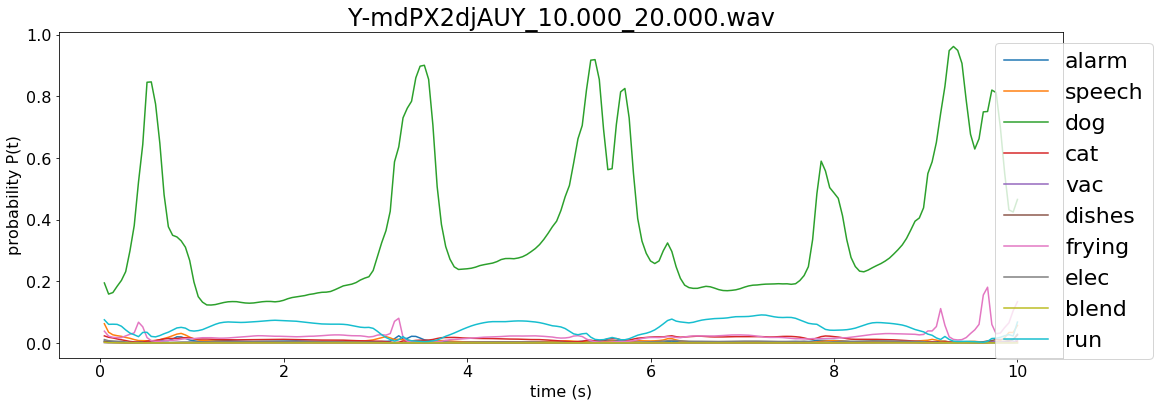

1

In [137]:
params = {'legend.fontsize': 22,
          'legend.handlelength': 2}
plt.rcParams.update(params)

for i in range(len(prediction[:nbFileToDisplay])):
    clip = prediction[i]
    file = featTestList[i]
    nbFrame = prediction.shape[1]
    frameLength = 10 / nbFrame
    print(file)
    rawBoundaries = getClasses(file)
    print(rawBoundaries)
    
    classes = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water".split(",")
    output = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water\n"
    
    with open(file + ".csv", "w") as toSave:
        frameCounter = 0
        for frame in clip:
            frameCounter += 10 / nbFrame
            output += "%.4f," % frameCounter
            for cls in frame:
                output += "%.4f," % cls
            output += "\n"
        toSave.write(output)
        
    display(file + ".csv", patches="test")
        
# clean the CSV files
call(["rm", "*.csv"])

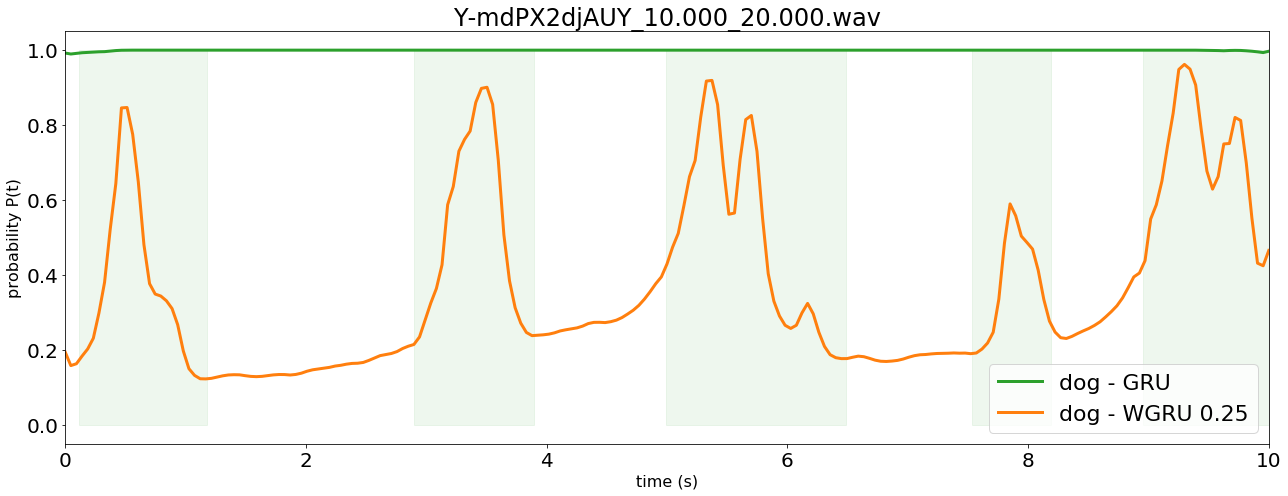

In [139]:
time = np.linspace(0, 10, 215)
fig, ax = plt.subplots(1, figsize=(18,7))
plt.title("Y-mdPX2djAUY_10.000_20.000.wav", fontsize=24)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("probability P(t)", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=20)


for r in patchessss[-5:]:
    ax.add_patch(r)

ax.plot(time, aaaaaaaaaaaaaaaaa[0], label="dog - GRU", color="C2", linewidth=3)
ax.plot(time, aaaaaaaaaaaaaaaaa[1], label="dog - WGRU 0.25", color="C1", linewidth=3)
ax.set_xlim([0, 10])
plt.tight_layout()

#ax.plot(time, blk, label="blk", color=Colors[classes.index("blank")])
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.00))